In [1]:
import pandas as pd

pd.set_option("display.precision", 3)
import os
import warnings

warnings.filterwarnings("ignore")
from sklearn.cluster import SpectralClustering
from mvlearn.cluster import MultiviewKMeans
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import sys
import math
import seaborn as sns

sns.set_style("white")
from ConsensusClusteringMultiView import ConsensusCluster
import scipy.stats as sps
import copy
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.lines as mlines
from sklearn.cluster import DBSCAN
from pathlib import Path
from random import shuffle
import scipy.stats as stats

from mpl_chord_diagram import chord_diagram

In [ ]:
def cal_flux(data, elements, significant, overall_mean):
    enrichment = []
    num_cluster = len(np.unique(data["assignment"].tolist()))
    for c in np.unique(data["assignment"].tolist()):
        data_run = data.copy()
        cluster = data_run[data_run["assignment"] == c]
        data_run.loc[
            data_run[data_run["assignment"] != c].index, "assignment"
        ] = "R"
        for el in elements:
            if cluster[el].mean() > overall_mean[el]:
                diff = cluster[el].mean() - overall_mean[el]
                contingency_table = pd.crosstab(
                    data_run[el], data_run["assignment"]
                )
                p_val = stats.fisher_exact(contingency_table)[1]
                if significant:
                    if p_val < (0.05 / (num_cluster * 6)):
                        enrichment.append([c, el, np.round(diff, 3)])
                else:
                    enrichment.append([c, el, np.round(diff, 3)])
    sign_diff = pd.DataFrame(np.array(enrichment))
    sign_diff.columns = ["cluster", "element", "diff"]
    if '.' in sign_diff["element"].iloc[0]:
        sign_diff["element"] = sign_diff["element"].str.split(".", expand=True)[1]
    elif '_' in sign_diff["element"].iloc[0]: 
        sign_diff["element"] = sign_diff["element"].str.split("_", expand=True)[1]
    sign_diff["cluster"]  = sign_diff.cluster.astype(float).astype(int)
    names = sign_diff.cluster.unique().tolist() + sign_diff.element.unique().tolist()
    sign_diff_expand = pd.DataFrame(columns=names, index=names)
    for c in sign_diff.cluster.unique():
        for el in sign_diff.element.unique():
            diff = (
                sign_diff[(sign_diff["cluster"] == c) & (sign_diff["element"] == el)][
                    "diff"
                ]
                .astype(float)
                .values
            )
            if len(diff) != 0:
                sign_diff_expand.loc[c, el] = diff[0]

    sign_diff_expand = sign_diff_expand.fillna(0)
    sign_diff_expand = sign_diff_expand.div(
        sign_diff_expand.sum(axis=1), axis=0
    ).fillna(0)
    return sign_diff_expand, names

In [2]:
configs = [
    ["clinical", 4, "DBSCAN"],
    ["contextual", 6, "DBSCAN"],
    ["physio", 4, "ConsensusKMeans"],
    ["proteome", 5, "DBSCAN"]
]

# organs

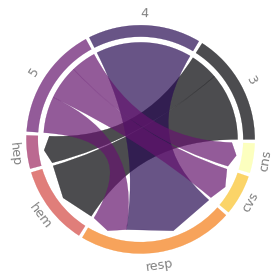

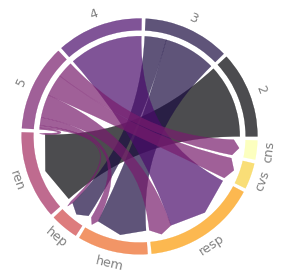

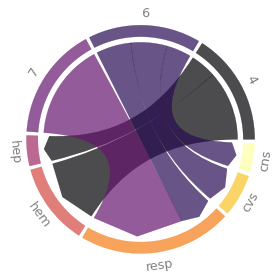

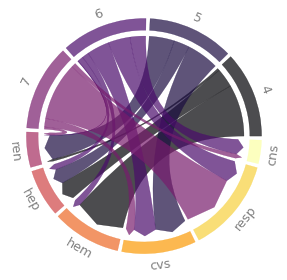

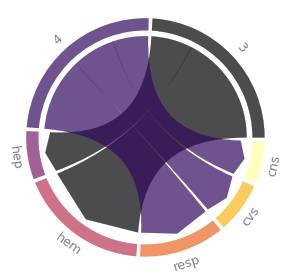

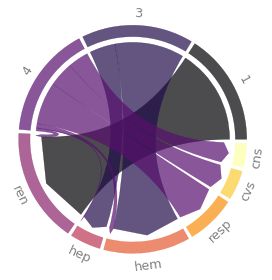

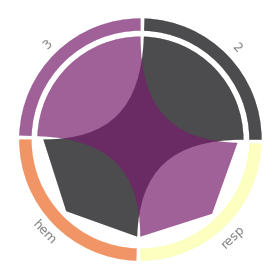

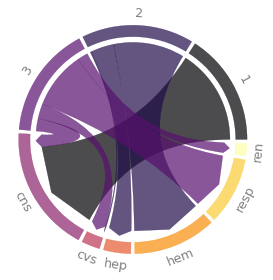

In [3]:
for i in range(len(configs)):
    view, KCC_space, method = configs[i]
    for significant in [True, False]:
        data_path = "data"
        result_path = "{}/ClusteringResults/".format(data_path)
        physio = pd.read_csv("{}/PhysioViewMICEimputed.csv".format(data_path), index_col=0)
        refer_id = pd.read_csv("data/ContextualViewStandardized.csv", index_col=0)
        scores = [
            "cons05.resp",
            "cons05.cvs",
            "cons05.cns",
            "cons05.ren",
            "cons05.hep",
            "cons05.hem",
        ]
        cons_scores = physio[
            [
                "cons05.resp",
                "cons05.cvs",
                "cons05.cns",
                "cons05.ren",
                "cons05.hep",
                "cons05.hem",
            ]
        ]
        cons_scores = cons_scores[cons_scores.index.isin(refer_id.index)]
        assignments = pd.read_csv(
            "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(result_path, method, view, KCC_space),
            index_col=0,
        )
        if method == 'DBSCAN':
            assignments["assignment"] = assignments["assignment"] + 1
            assignments["assignment"] = assignments[assignments["assignment"] != 0]
        num_cluster = len(np.unique(assignments["assignment"].tolist()))
        cons_scores["assignment"] = assignments["assignment"]
        cons_scores = cons_scores[cons_scores["assignment"].notnull()]
        overall_mean = cons_scores.mean()[scores]
        
        sign_diff_expand, names = cal_flux(cons_scores, scores, significant, overall_mean)
        

        flux = sign_diff_expand.values
        chord_diagram(flux, names, gap=0.05, use_gradient=True, sort='distance', directed=True,
                      cmap='inferno', chord_colors=None, rotate_names=False, fontcolor='grey')
        #plt.title("{}".format(view.upper()), fontsize=20)
        plt.tight_layout()
        if significant:
            plt.savefig('data/ChordDiagrams/Significant_{}_organs.png'.format(view.upper()), dpi=300)
        else:
            plt.savefig('data/ChordDiagrams/{}_organs.png'.format(view.upper()), dpi=300)
        plt.show()

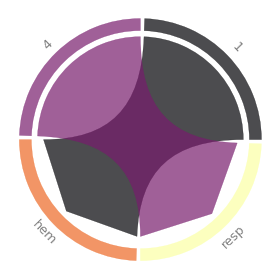

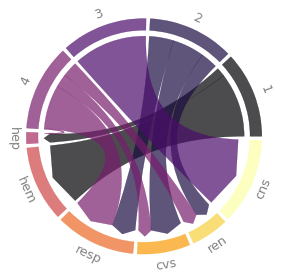

In [4]:
for significant in [True, False]:
    data_path = "data"
    result_path = "{}/MVKDR_results/".format(data_path)
    physio = pd.read_csv("{}/PhysioViewMICEimputed.csv".format(data_path), index_col=0)
    refer_id = pd.read_csv("data/ContextualViewStandardized.csv", index_col=0)
    scores = [
        "cons05.resp",
        "cons05.cvs",
        "cons05.cns",
        "cons05.ren",
        "cons05.hep",
        "cons05.hem",
    ]
    cons_scores = physio[
        [
            "cons05.resp",
            "cons05.cvs",
            "cons05.cns",
            "cons05.ren",
            "cons05.hep",
            "cons05.hem",
        ]
    ]
    cons_scores = cons_scores[cons_scores.index.isin(refer_id.index)]
    assignments = pd.read_csv(
        "{}/proteome_clinical_K_4_assignments_ranked.csv".format(result_path),
        index_col=0,
    )
    num_cluster = len(np.unique(assignments["assignment"].tolist()))
    cons_scores["assignment"] = assignments["assignment"]
    cons_scores = cons_scores[cons_scores["assignment"].notnull()]
    overall_mean = cons_scores.mean()[scores]
    
    sign_diff_expand, names = cal_flux(cons_scores, scores, significant, overall_mean)

    flux = sign_diff_expand.values
    chord_diagram(flux, names, gap=0.05, use_gradient=True, sort='distance', directed=True,
                  cmap='inferno', chord_colors=None, rotate_names=False, fontcolor='grey')
    #plt.title("{}".format('MV'), fontsize=20)
    plt.tight_layout()
    if significant:
        plt.savefig('data/ChordDiagrams/Significant_{}_organs.png'.format('MV'), dpi=300)
    else:
        plt.savefig('data/ChordDiagrams/{}_organs.png'.format('MV'), dpi=300)
    plt.show()

# pathogen

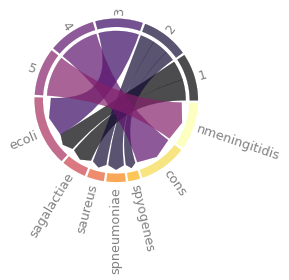

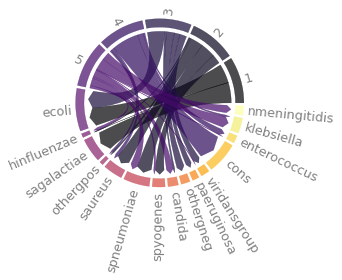

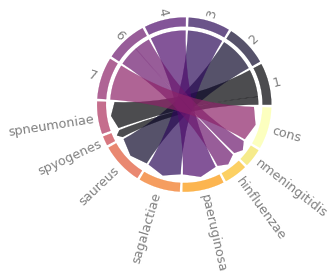

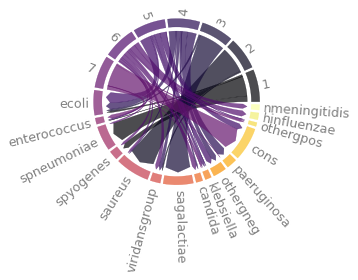

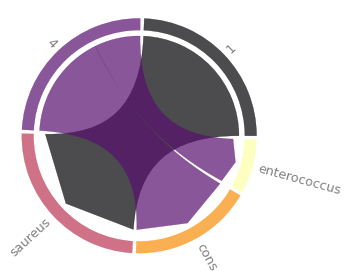

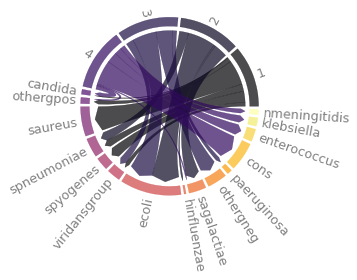

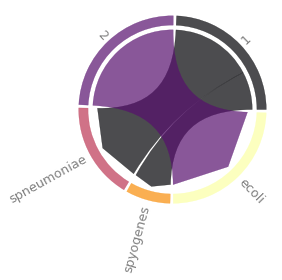

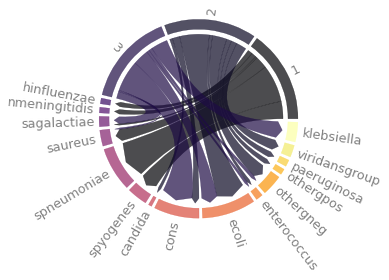

In [7]:
pathogen_cols = [
    "patho_candida",
    "patho_cons",
    "patho_ecoli",
    "patho_enterococcus",
    "patho_hinfluenzae",
    "patho_klebsiella",
    "patho_nmeningitidis",
    "patho_othergneg",
    "patho_othergpos",
    "patho_paeruginosa",
    "patho_sagalactiae",
    "patho_saureus",
    "patho_spneumoniae",
    "patho_spyogenes",
    "patho_viridansgroup",
]

for i in range(len(configs)):
    view, KCC_space, method = configs[i]
    for significant in [True, False]:
        data_path = "data"
        result_path = "{}/ClusteringResults/".format(data_path)
        contextual = pd.read_csv("{}/ContextualViewZeroImputed.csv".format(data_path), index_col=0)
        assignments = pd.read_csv(
            "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(result_path, method, view, KCC_space),
            index_col=0,
        )
        if method == 'DBSCAN':
            assignments["assignment"] = assignments["assignment"] + 1
            assignments["assignment"] = assignments[assignments["assignment"] != 0]
        pathogens = contextual[pathogen_cols]
        pathogens["assignment"] = assignments["assignment"]
        pathogens = pathogens[pathogens["assignment"].notnull()]
        overall_mean = pathogens.mean()[pathogen_cols]

        sign_diff_expand, names = cal_flux(pathogens, pathogen_cols, significant, overall_mean)

        flux = sign_diff_expand.values
        chord_diagram(flux, names, gap=0.05, use_gradient=True, sort='distance', directed=True,
                      cmap='inferno', chord_colors=None, rotate_names=True, fontcolor='grey')
        plt.tight_layout()
        if significant:
            plt.savefig('data/ChordDiagrams/Significant_{}_pathogen.png'.format(view.upper()), dpi=300)
        else:
            plt.savefig('data/ChordDiagrams/{}_pathogen.png'.format(view.upper()), dpi=300)
        plt.show()

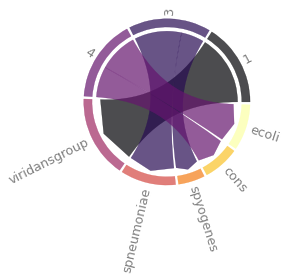

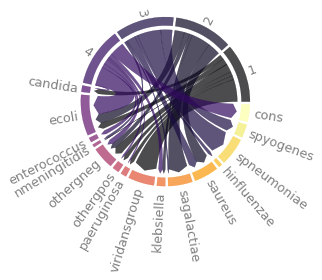

In [6]:

for significant in [True, False]:
    data_path = "data"
    result_path = "{}/MVKDR_results/".format(data_path)
    contextual = pd.read_csv("{}/ContextualViewZeroImputed.csv".format(data_path), index_col=0)
    assignments = pd.read_csv(
        "{}/proteome_clinical_K_4_assignments_ranked.csv".format(result_path),
        index_col=0,
    )
    pathogens = contextual[pathogen_cols]
    pathogens["assignment"] = assignments["assignment"]
    pathogens = pathogens[pathogens["assignment"].notnull()]
    overall_mean = pathogens.mean()[pathogen_cols]

    sign_diff_expand, names = cal_flux(pathogens, pathogen_cols, significant, overall_mean)
    
    flux = sign_diff_expand.values
    chord_diagram(flux, names, gap=0.05, use_gradient=True, sort='distance', directed=True,
                  cmap='inferno', chord_colors=None, rotate_names=True, fontcolor='grey')
    plt.tight_layout()
    if significant:
        plt.savefig('data/ChordDiagrams/Significant_{}_pathogen.png'.format('MV'), dpi=300)
    else:
        plt.savefig('data/ChordDiagrams/{}_pathogen.png'.format('MV'), dpi=300)
    plt.show()

# infection focus

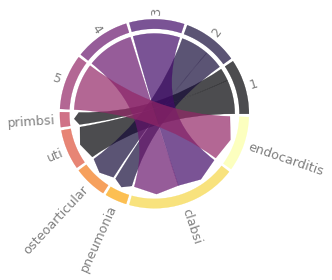

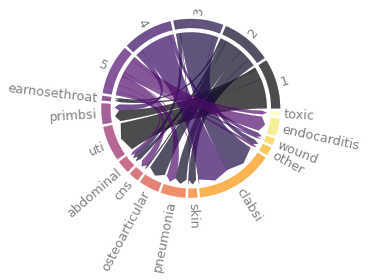

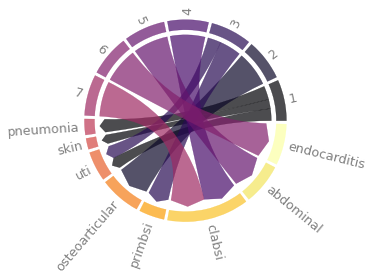

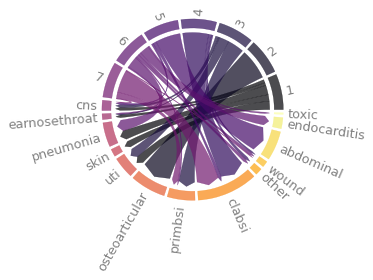

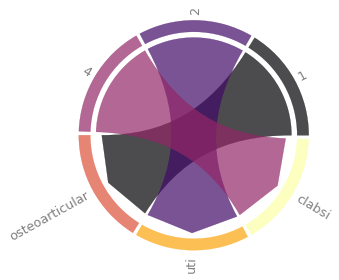

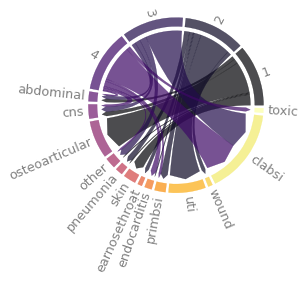

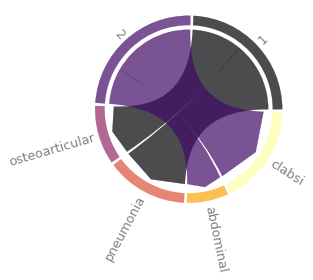

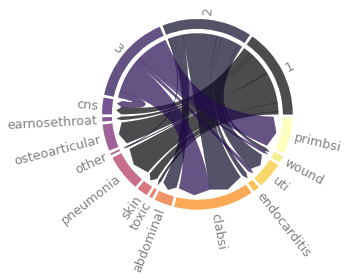

In [11]:
infection_cols = [
    "focus_abdominal",
    "focus_clabsi",
    "focus_cns",
    "focus_earnosethroat",
    "focus_endocarditis",
    "focus_osteoarticular",
    "focus_other",
    "focus_pneumonia",
    "focus_primbsi",
    "focus_skin",
    "focus_toxic_shock",
    "focus_uti",
    "focus_wound"
]
for i in range(len(configs)):
    view, KCC_space, method = configs[i]
    for significant in [True, False]:
        data_path = "data"
        result_path = "{}/ClusteringResults/".format(data_path)
        contextual = pd.read_csv("{}/ContextualViewZeroImputed.csv".format(data_path), index_col=0)
        assignments = pd.read_csv(
            "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(result_path, method, view, KCC_space),
            index_col=0,
        )
        if method == 'DBSCAN':
            assignments["assignment"] = assignments["assignment"] + 1
            assignments["assignment"] = assignments[assignments["assignment"] != 0]
        infections = contextual[infection_cols]
        infections["assignment"] = assignments["assignment"]
        infections = infections[infections["assignment"].notnull()]
        overall_mean = infections.mean()[infection_cols]

        sign_diff_expand, names = cal_flux(infections, infection_cols, significant, overall_mean)

        flux = sign_diff_expand.values
        chord_diagram(flux, names, gap=0.05, use_gradient=True, sort='distance', directed=True,
                      cmap='inferno', chord_colors=None, rotate_names=True, fontcolor='grey')
        plt.tight_layout()
        if significant:
            plt.savefig('data/ChordDiagrams/Significant_{}_infection.png'.format(view.upper()), dpi=300)
        else:
            plt.savefig('data/ChordDiagrams/{}_infection.png'.format(view.upper()), dpi=300)
        plt.show()

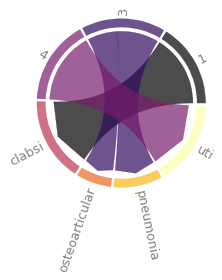

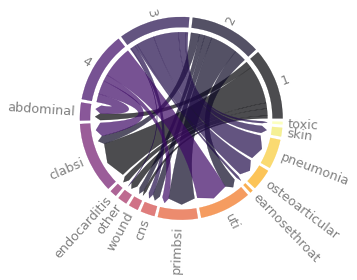

In [12]:

for significant in [True, False]:
    data_path = "data"
    result_path = "{}/MVKDR_results/".format(data_path)
    contextual = pd.read_csv("{}/ContextualViewZeroImputed.csv".format(data_path), index_col=0)
    assignments = pd.read_csv(
        "{}/proteome_clinical_K_4_assignments_ranked.csv".format(result_path),
        index_col=0,
    )
    infections = contextual[infection_cols]
    infections["assignment"] = assignments["assignment"]
    infections = infections[infections["assignment"].notnull()]
    overall_mean = infections.mean()[infection_cols]

    sign_diff_expand, names = cal_flux(infections, infection_cols, significant, overall_mean)
    
    flux = sign_diff_expand.values
    chord_diagram(flux, names, gap=0.05, use_gradient=True, sort='distance', directed=True,
                  cmap='inferno', chord_colors=None, rotate_names=True, fontcolor='grey')
    plt.tight_layout()
    if significant:
        plt.savefig('data/ChordDiagrams/Significant_{}_infection.png'.format('MV'), dpi=300)
    else:
        plt.savefig('data/ChordDiagrams/{}_infection.png'.format('MV'), dpi=300)
    plt.show()